In [53]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text

from Bio import SeqIO

from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [54]:
datadir = '../data/dnaPipeTE-out'
dnapipete_data = {sp: f'{datadir}/{sp}/Counts.txt' for sp in os.listdir(datadir)}

In [55]:
def read_counts(countfile):
    count_df = pd.read_csv(countfile, sep='\t', header=None, names=['teclass', 'readcount'])
    return count_df

def count_finz(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

In [77]:
count_dfs = []
for sp, val in dnapipete_data.items():
    count_df = read_counts(val)
    count_df['species'] = sp
    count_df['finz'] = count_finz(sp)
    count_dfs.append(count_df)

count_df = pd.concat(count_dfs)
count_df = count_df.pivot_table(index=['species', 'finz'], 
                                columns='teclass', 
                                values='readcount') \
    .sort_values('finz') \
    .reset_index()
count_df['Unknown'] = count_df.na + count_df.others
count_df = count_df.drop(['Others', 'Tandem_repeats', 'na', 'others', 'rRNA', 'MITE', 'Simple_repeat'], axis=1)
count_df['interspersed'] = count_df.DNA + count_df.LTR + count_df.LINE + count_df.SINE + count_df.Helitron
for teclass in ['DNA', 'Helitron', 'LINE', 'LTR', 'SINE', 'Low_Complexity', 'Satellite', 'Unknown', 'interspersed', 'Total']:
    count_df[teclass] = count_df[teclass]/count_df['Total']*100 

print(count_df.head()
count_df.to_csv('../data/finz_te_counts.txt', sep='\t', header=True, index=False)

teclass                     species  finz        DNA  Helitron      LINE  \
0              Triplophysa_tibetana     0  11.535100  0.353564  4.109580   
1            Triplophysa_siluroides     0  11.144761  0.165809  2.899348   
2                Danionella_dracula     0   5.642604  0.563075  3.757688   
3            Danionella_translucida     4   7.711250  1.695768  2.048340   
4        Poropuntius_huangchuchieni     8   9.116787  0.203333  1.180123   

teclass       LTR  Low_Complexity      SINE  Satellite  Total   Unknown  \
0        4.397636        0.046156  0.414028   0.150996  100.0  8.651206   
1        4.312603        0.036850  0.296132   0.086445  100.0  7.162924   
2        4.499909        0.005209  0.621013   0.050368  100.0  5.272346   
3        2.897715        0.002425  0.048013   0.227442  100.0  7.381324   
4        1.830937        0.037739  0.166368   1.400176  100.0  5.850739   

teclass  interspersed  
0           20.809909  
1           18.818653  
2           15.08428

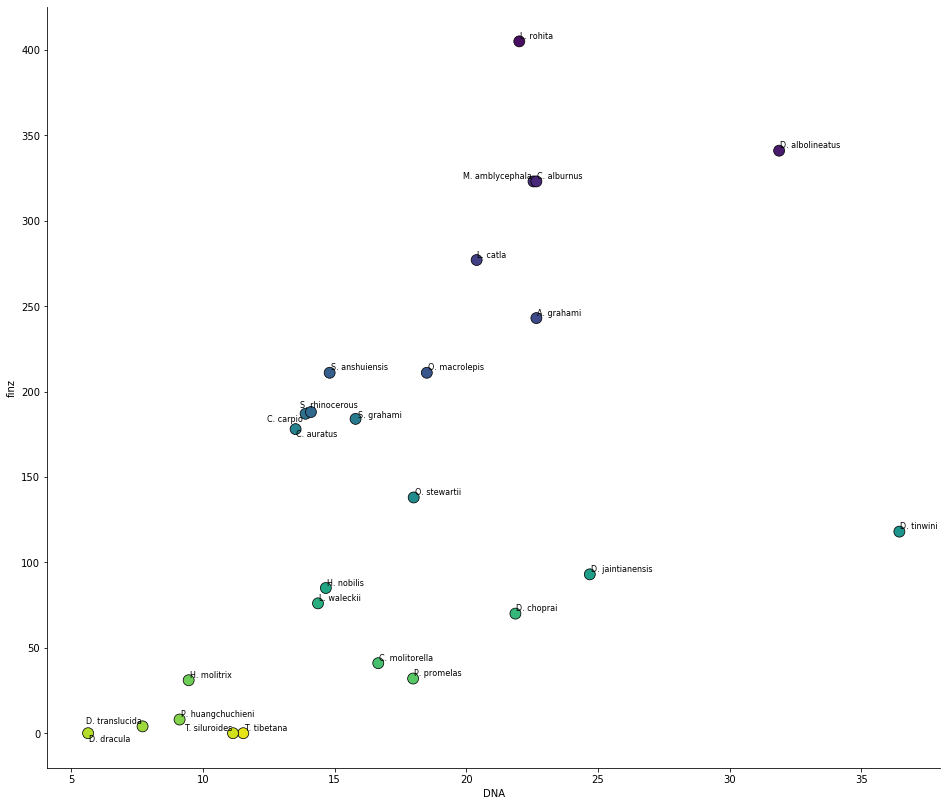

SpearmanrResult(correlation=0.6861742151734255, pvalue=0.00010883773594270965)


In [81]:
column = 'DNA'
fig, ax = plt.subplots(figsize=(16, 14))
sns.scatterplot(data=count_df.loc[~count_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])], 
                x=column, 
                y='finz',
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=120,
                ax=ax)
ax.get_legend().remove()

labels = []
for row in count_df.loc[~count_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])].iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1][column], row[1]['finz'], label, size=8, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()
print(stats.spearmanr(count_df.loc[~count_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])][column], 
                      count_df.loc[~count_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])]['finz']))

A possible explanation for some of the noise in the correlation is genome assembly quality. Since the finz-znfs are normally present on specific, highly repetitive chromosomes, it is possible that low numbers of predicted genes could be due to collapsing or fragmentation of these regions. To test this, we will look at the correlation between N50 and finz count.

In [78]:
def calc_N50(genomefile):
    contiglens = []
    for record in SeqIO.parse(genomefile, 'fasta'):
        contiglens.append(len(record.seq))
    contiglens = sorted(contiglens, reverse=True)
    gsize = sum(contiglens)
    i, currentsize = 0, 0
    while currentsize <= gsize*0.5:
        currentsize += contiglens[i]
        i += 1
    return contiglens[i]

with open('../data/species_genomes.txt') as infile:
    genomes = {line.split()[0]: f'/Users/jonwells/Genomes/Cypriniformes/ncbi-genomes-2020-07-09/{line.split()[1]}' for line in infile}

n50s = []
for species, genomefile in genomes.items():
    n50s.append((species, calc_N50(genomefile)))
n50_df = pd.DataFrame(n50s, columns=['species', 'N50'])
n50_df = n50_df.merge(count_df, on='species')
print(n50_df.head())

                        species      N50  finz        DNA  Helitron      LINE  \
0           Pimephales_promelas    60365    32  17.983488  0.346771  1.834706   
1               Cyprinus_carpio  7653411   187  13.901122  0.719657  4.009053   
2  Sinocyclocheilus_anshuiensis  1282074   211  14.814240  0.349348  2.304985   
3  Sinocyclocheilus_rhinocerous   945578   188  14.103385  0.308016  2.142732   
4      Sinocyclocheilus_grahami  1156011   184  15.798656  0.263180  2.629399   

        LTR  Low_Complexity      SINE  Satellite  Total    Unknown  \
0  2.983876        0.044337  0.226264   1.198272  100.0  12.860465   
1  3.482556        0.053705  0.409140   1.808048  100.0  10.120813   
2  3.698811        0.056139  0.360871   2.071782  100.0  10.085686   
3  3.394562        0.032997  0.283832   2.070005  100.0  10.516408   
4  4.357701        0.039877  0.352033   1.939387  100.0  11.368929   

   interspersed  
0     23.375106  
1     22.521528  
2     21.528255  
3     20.232527  
4 

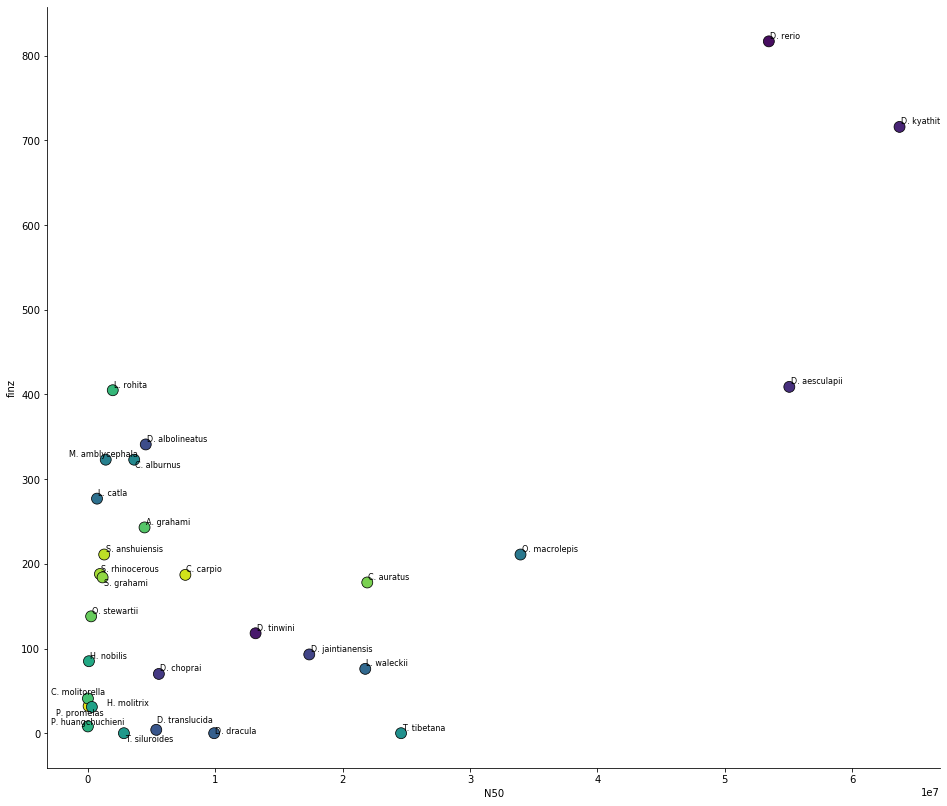

SpearmanrResult(correlation=0.005475704460236813, pvalue=0.9788205175392344)
(-0.10986934204058295, 0.5931371336712967)


In [80]:
fig, ax = plt.subplots(figsize=(16, 14))
# sns.scatterplot(data=n50_df.loc[~n50_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])], 
sns.scatterplot(data=n50_df, 
                x='N50', 
                y='finz',
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=120,
                ax=ax)
ax.get_legend().remove()
labels = []
for row in n50_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1]['N50'], row[1]['finz'], label, size=8, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()


print(stats.spearmanr(n50_df.loc[~n50_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])].N50, n50_df.loc[~n50_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])].finz))
print(stats.pearsonr(n50_df.loc[~n50_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])].N50, n50_df.loc[~n50_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])].finz))

In [ ]:
print()